In this notebook we give a proof of concept of unitary compiling using TFQ. 

In [1]:
%load_ext autoreload
%autoreload 2

import sympy 
import numpy as np 
import pandas as pd 
import tensorflow as tf
from utilities.circuit_database import CirqTranslater
from utilities.templates import *
from utilities.variational import Minimizer
import matplotlib.pyplot as plt 
import tensorflow_quantum as tfq
import cirq
from utilities.compiling import *
from utilities.misc import *
from utilities.simplifier import Simplifier
from utilities.discrimination import *
from utilities.idinserter import IdInserter
from utilities.evaluator import Evaluator
from utilities.gate_killer import GateKiller
from ast import literal_eval
import tensorflow_quantum as tfq
from tqdm import tqdm

In [2]:
etas = np.loadtxt("inputs/inputs.csv")

In [3]:
circuits = {}
costs = {}
optimals = {}
best_found={}
for ets in tqdm(etas):

    translator = CirqTranslater(3, untouchable_blocks = [1], discard_qubits=[2])
    simplifier = Simplifier(translator)
    inserter = IdInserter(translator.n_qubits, untouchable_blocks=translator.untouchable_blocks, untouchable_qubits = [2])
    killer = GateKiller(translator, mode="discrimination", params=ets)
    minimizer = Minimizer(translator, mode="discrimination", params=ets)

    args_evaluator = {"n_qubits":translator.n_qubits, "problem":"acd","params":ets}
    evaluator = Evaluator(args=args_evaluator, lower_bound_cost=minimizer.lower_bound_cost, nrun=0, stopping_criteria=1e-3)

    evaluator.load_dicts_and_displaying(evaluator.identifier)
    [circuit_db, cost, lowest_cost, lower_bound, acceptance_percentage, operation, history] = evaluator.evolution[len(evaluator.evolution.keys())-1]
    costs[str(ets)] = cost
    optimals[str(ets)] = lower_bound
    circuits[str(ets)] = circuit_db
    best_found[str(ets)] = lowest_cost

100%|██████████| 210/210 [00:47<00:00,  4.38it/s]


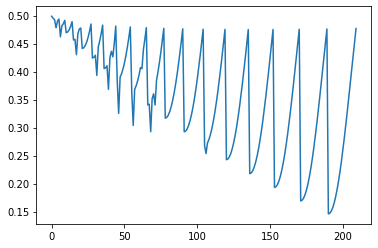

In [4]:
plt.plot(np.array(list(best_found.values())))

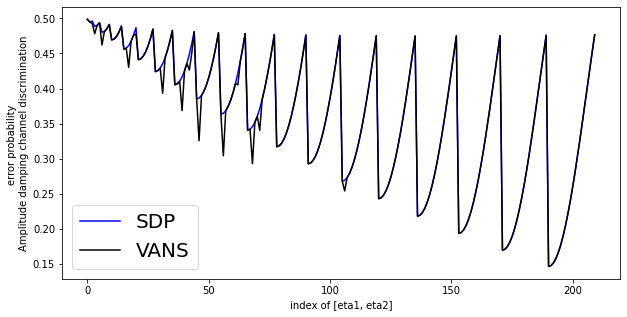

In [8]:
plt.figure(figsize=(10,5))
plt.plot(np.array(list(optimals.values())), color="blue", label="SDP")
plt.plot(np.array(list(best_found.values())), color="black", label="VANS")
plt.ylabel("error probability \nAmplitude damping channel discrimination")
plt.xlabel("index of [eta1, eta2]")
plt.legend(prop={"size":20})

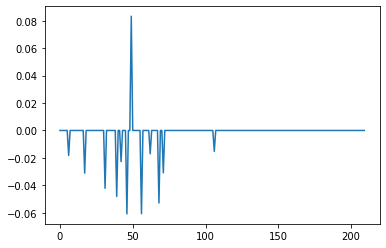

In [66]:
plt.plot(diffs)

In [40]:
diffs = np.array(list(costs.values())) - np.array(list(optimals.values()))
diffs_best = np.array(list(best_found.values())) - np.array(list(optimals.values()))

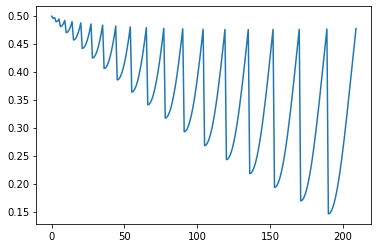

In [60]:
plt.plot(np.array(list(optimals.values())))

In [76]:
ets = [0.75, 0.7]
translator = CirqTranslater(3, untouchable_blocks = [1], discard_qubits=[2])
simplifier = Simplifier(translator)
inserter = IdInserter(translator.n_qubits, untouchable_blocks=translator.untouchable_blocks, untouchable_qubits = [2])
killer = GateKiller(translator, mode="discrimination", params=ets)
minimizer = Minimizer(translator, mode="discrimination", params=ets)

args_evaluator = {"n_qubits":translator.n_qubits, "problem":"acd","params":ets}
evaluator = Evaluator(args=args_evaluator, lower_bound_cost=minimizer.lower_bound_cost, nrun=0, stopping_criteria=1e-3)

evaluator.load_dicts_and_displaying(evaluator.identifier)


In [78]:
evaluator.evolution[len(evaluator.evolution)-1]

[    ind symbol  param_value  trainable  block_id channel_param
 0     9   th_0    -3.141594       True         0           NaN
 1    10   th_1    -0.321156       True         0           NaN
 2    15   None          NaN      False         1           NaN
 3    17   None          NaN      False         1           NaN
 4     4   None          NaN      False         1           NaN
 5    14   th_2     1.000000      False         1          True
 6     4   None          NaN      False         1           NaN
 7    15   None          NaN      False         1           NaN
 8    17   None          NaN      False         1           NaN
 9    14   th_3     1.000000      False         1          True
 10    4   None          NaN      False         1           NaN
 11    9   th_4     0.000005       True         2           NaN
 12   10   th_5     0.321166       True         2           NaN,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.47519338>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.

In [55]:
lower_bound

0.4767856972177551

In [41]:
np.max(diffs_best)

8.651475542631459e-07

In [43]:
np.min(diffs_best)

-0.060851406662900454

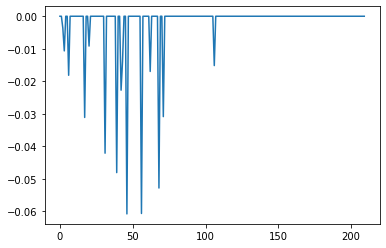

In [54]:
plt.plot(diffs_best)

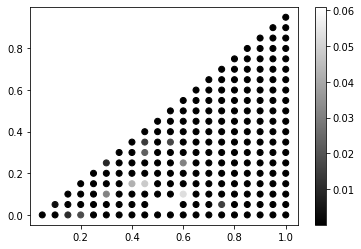

In [46]:
plt.scatter(etas[:,0],etas[:,1], c=np.abs(diffs_best))
plt.gray()
plt.colorbar()

In [48]:
etas[np.argmax(diffs_best)]

array([0.75, 0.7 ])

In [74]:
db = translator.give_circuit(circuits[str(etas[np.argmax(diffs_best)])])[0]

In [75]:
db

(0, 0): ───Rx(th_0)───H──────────X────────────────X───H────────────────X───Rx(th_4)───
                                 │                │                    │
(0, 1): ───Rx(th_1)───Rx(th_5)───┼────────────────┼────────────────────┼──────────────
                                 │                │                    │
(0, 2): ───H─────────────────────@───Ry(0.318π)───@───H───Ry(0.318π)───@──────────────

In [15]:
circuit, circuit_db = translator.give_circuit(circuit_db, unresolved = False)

In [16]:
circuit

(0, 0): ───Rx(π)────────H─────────────X────────────────X───H────────────────X───Rx(-π)───
                                      │                │                    │
(0, 1): ───Rx(0.114π)───Rx(-0.114π)───┼────────────────┼────────────────────┼────────────
                                      │                │                    │
(0, 2): ───H──────────────────────────@───Ry(0.318π)───@───H───Ry(0.318π)───@────────────